# Preprocessing and gap filling

Verkko-fillet is an easy-to-use toolkit for finishing [Verkko](https://github.com/marbl/verkko) assemblies. Here we begin with tools for generating a Verkko-Fillet object, performing assembly quality checks, identifying gaps, assigning chromosomes, searching for ONT reads to help resolve gaps, filling gaps, and generating the final Rukki path (in a GAF-like format) for future Verkko CNS runs.

This Python-based implementation streamlines the entire process. Here we assume the initial Verkko run completed and is ready for the graph curation. The goal is to prepare a post-curated path to walk through the assembly graph for re-doing the final consensus run with minimal manual intervention.

In [106]:
%load_ext autoreload
%autoreload 2


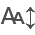

In [2]:
import sys 
import importlib
import pandas as pd
import time
import os
from IPython.display import Image, display
pd.set_option('mode.chained_assignment', None)
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import warnings
import session_info
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [124]:
import verkkofillet as vf
importlib.reload(vf)

verkko-fillet version:0.1.8
verkko-fillet version:0.1.8


<module 'verkkofillet' from '/gpfs/gsfs11/users/kimj75/miniforge3/envs/verkko-fillet-local/lib/python3.9/site-packages/verkkofillet/__init__.py'>

The `verkkoFillet` module, abbreviated as `vf`, consists of three sub-modules: `pp`, `tl`, and `pl`.

- **`vf.tl`**: Provides tools for running shell scripts.  
- **`vf.pp`**: Includes modules for preprocessing and modifying datasets.  
- **`vf.pl`**: Dedicated to plotting and visualization.  

## Loading verkko directory into the verkko-fillet object

The input file is very simple. You only need the Verkko output directory.

In [4]:
verkkoDir="/path/to/verkko_result_directory/"

In [5]:
obj = vf.pp.read_Verkko(verkkoDir)

The Verkko fillet target directory already exists: /path/to/verkko_result_directory_verkko_fillet
If you didn't mean this, please set another directory or for overwirting, please use force= True
Lock the original Verkko folder to prevent it from being modified.
[lock_original_folder] Command executed successfully!
Path file loading...from /path/to/verkko_result_directory_verkko_fillet/assembly.paths.tsv
Path file loaded successfully.
scfmap file not found or path is None.


In [6]:
obj

FilletObj
  verkkoDir: /path/to/verkko_result_directory
  verkko_fillet_dir: /path/to/verkko_result_directory_verkko_fillet
  paths: name, path, assignment
  history: timestamp, activity, function

In [9]:
print(obj.verkko_fillet_dir)
os.chdir(obj.verkko_fillet_dir)

/path/to/verkko_result_directory_verkko_fillet


The Verkko-fillet object will read all files in the Verkko output directory, including the final Rukki path file, ONT alignment, and others, if they exist. However, don't worry if your Verkko directory does not have all these files. In this Jupyter notebook, we will generate all the necessary files and statistics and load them into the Verkko-fillet object later. Once you build your own Verkko Fillet object, you can save it locally as a Python pickle file, allowing you to load it anytime for future curation tasks.

You can use the Verkko-fillet Python module to view and edit the object using specific functions. Additionally, you can easily access each piece of data stored in the object through its attributes (e.g., `obj.verkkoDir`).

When you print the object, it will display the types of data stored within it.


## Stats

Before starting curation and polishing the assembly, it is helpful to examine the statistics and quality of the initial assembly. 

Firstly, run the `vf.pp.getT2T` function to retrieve the T2T statistics, including the number of scaffolds, contigs, telomeres, and gaps. This function generates four files in the Verkko output directory using the `assembly.fasta` file:  

- `assembly.telomere.bed`  
- `assembly.gaps.bed`  
- `assembly.t2t_scfs`  
- `assembly.t2t_ctgs`  


In [10]:
%%time
vf.tl.getT2T(obj)

getT2T was done!
CPU times: user 0 ns, sys: 8.84 ms, total: 8.84 ms
Wall time: 1min 12s


## Collapse rDNA nodes. 

As default, `vf.tl.rmrDNA` function uses the homopolymer-compressed rDNA morphs to screen and collapse rDNA nodes in the Verkko graph, along with the `assembly.telomere.bed` file generated above using `vf.tl.getT2T(obj)`. This process marks telomere nodes at the end of the contigs and generates three output files:

1. **`target.screennodes.out`**: This file includes the nodes that have rDNA sequences.
2. **`assembly.homopolymer-compressed.noseq.telo_rdna.gfa`**: The graph with the rDNA collapsed and telomere nodes added.
3. **`assembly.colors.telo_rdna.csv`**: Adds telomere nodes marked in green (#008000) and rDNA nodes marked in purple (#A020F0), in addition to the original `assembly.colors.csv`.


In [41]:
%%time
vf.tl.rmrDNA(obj)

Starting removing rDNA nodes in the graph
All output files already exist. Skipping rDNA removal.
CPU times: user 1.17 ms, sys: 19 µs, total: 1.19 ms
Wall time: 2.02 ms


## QV calculation

**QV (Quality Value)** is a fundamental metric for assessing the quality of an assembly. 

The input for QV calculation is a list of high-quality sequencing data, such as HiFi reads, used for the Verkko assembly. K-mers are extracted separately from the sequencing data and the reference assembly. The number of shared k-mers between the two is then used to calculate the QV. 

- A **high QV** indicates a high-quality assembly, where most k-mers are shared with the original high-quality sequencing reads.  
- A **low QV** suggests that the assembly contains many errors not present in the high-quality sequencing data.  
                                                                      

fofn file contains one column of file paths to the fastq files.

In [16]:
fofn = "/path/to/child.fofn"
kmerPrefix="child_illumina"

the kmer databases for each data and assembly will generatedd by `meryl`

We will use `meryl` to generate a k-mer database from raw reads using the `vf.tl.mkMeryl()` function. Then, we will calculate the QV score for each haplotype and the combined assembly by utilizing merqury within the `vf.tl.calQV()` function.

Please ensure that merqury is installed and update your `~/.profile` to include the `$MERQURY` global variable. This allows it to be used as described in the [`merqury` GitHub repository.](https://github.com/marbl/merqury).

In [ ]:
%%time
vf.tl.mkMeryl(obj, fofn, prefix=kmerPrefix)

In [ ]:
%%time
vf.tl.calQV(obj, prefix=kmerPrefix)

In [19]:
obj = vf.pp.getQV(obj, f"kmer/{kmerPrefix}.qv_cal.qv")

In [20]:
obj

FilletObj
  verkkoDir: /path/to/verkko_result_directory
  verkko_fillet_dir: /path/to/verkko_result_directory_verkko_fillet
  paths: name, path, assignment
  qv: asmName, nKmer_uniq_asm, nKmer_total, QV, ErrorRate
  history: timestamp, activity, function

In [21]:
obj.qv

asmName  nKmer_uniq_asm  nKmer_total       QV     ErrorRate
0  assembly_mat           16342   2543978946  66.8357  2.072200e-07
1  assembly_pat           57324   2435327618  61.1958  7.593160e-07
2          both           73666   4979306564  63.2126  4.772430e-07

Each column shows:

1. **Assembly of interest**: This is a combination of the two datasets mentioned above.  
2. **K-mers uniquely found only in the assembly**  
3. **K-mers found in both the assembly and the read set**  
4. **QV (Quality Value)**  
5. **Error rate**  

For more detailed information, please visit the [Merqury GitHub](https://github.com/marbl/merqury).


/gpfs/gsfs11/users/kimj75/miniforge3/envs/verkko-fillet-local/lib/python3.9/site-packages/verkkofillet/plotting/_baseQC.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


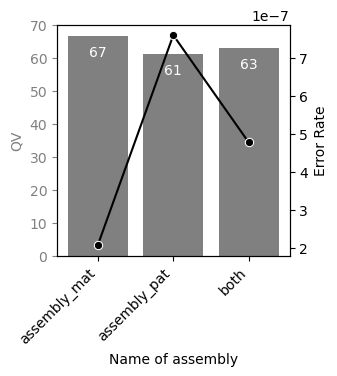

In [22]:
vf.pl.qvPlot(obj)

## Chromosome assignment

To check which chromosomes are contigs and to pair the same chromosomes from two haplotypes, chromosome assignment is crucial. The `vf.tl.chrAssign` function will run `Mashmap` to align the assembly to a user-provided reference FASTA file and obtain high-confidence chromosome assignments for each contig in the assembly. Once this is done, we will load not only the chromosome assignment results but also the T2T stats generated earlier using the `vf.pp.getT2T` function.


If you have reference fasta with chromosome name that is not easy to read, for ecample start with "NC, CM.. ", you can convert the name of the fasta file using `vf.tl.convertRefName()` with reference fasta and map

The `chromosome.map` file has two columns: 

1. One column contains the names of contigs associated with each primary chromosome (starting with CN, CM, etc., in the reference FASTA file).  
2. The other column contains the names of the primary chromosomes (e.g., chr1, chr2, etc.).

Both columns should be unique. If you have more than one contig from same chromosome, please make them unique(ex. chr1_q, chr1_p)

These contig names need to be converted into easy-to-read chromosome names.


In [23]:
ref_fasta = "/path/to/ref/ncbiRef/GCA_017591445.1_ASM1759144v1_genomic.fna"
map_file="/path/to/chromosome.map"

In [20]:
# vf.tl.convertRefName(ref_fasta, map_file)

The function `vf.tl.convertRefName()` generates a FASTA file with the desired names specified in the `chromosome.map` file. The newly named file will have the suffix .rename.fa.

In [24]:
ref_fasta = "/path/to/ref/ncbiRef/GCA_017591445.1_ASM1759144v1_genomic.rename.fa"

[chrAssign] Command executed successfully!
CPU times: user 1.37 ms, sys: 4.79 ms, total: 6.16 ms
Wall time: 7.85 s


Before running chromosome assignment, we recommend to filter out noisy references. 
`vf.tl.filterContigs` function can do that with `map_file` or list of contigs given to `filter_chr_list` parameter.
This can be done by running the following command:

In [ ]:
%%time
vf.tl.filterContigs(map_file, ref_fasta)

In [ ]:
ref_fasta = "/path/to/ref/ncbiRef/GCA_017591445.1_ASM1759144v1_genomic.rename_filtered.fasta"

The `vf.tl.chrAssign` function uses mashmap to assign chromosomes to each contig in the assembly. If you set `force=True`, the function will remove all existing outputs in the output folder and restart the process from running `mashmap`.

In [ ]:
vf.tl.chrAssign(obj = obj, ref = ref)

If you have trio or parental information, you can assign which haplotype is paternal and which is maternal using `vf.pp.readChr` function. If trio information is not available and your contigs are labeled with 'haplotype' instead of 'sire' or 'mat,' these parameters will be ignored.

In [25]:
obj = vf.pp.readChr(obj, map_file, sire = "pat", dam = "mat")

The chromosome infomation was stored in obj.stats


In [26]:
obj

FilletObj
  verkkoDir: /path/to/verkko_result_directory
  verkko_fillet_dir: /path/to/verkko_result_directory_verkko_fillet
  paths: name, path, assignment
  stats: contig, ref_chr, contig_len, ref_chr_len, hap, old_chr, completeness, hap_verkko, t2tStat
  qv: asmName, nKmer_uniq_asm, nKmer_total, QV, ErrorRate
  history: timestamp, activity, function

In [27]:
obj.stats.head(2)

contig ref_chr  contig_len  ref_chr_len  hap  \
0   dam_compressed.k31.hapmer-0000009    chr1   225503047    210919050  mat   
1  sire_compressed.k31.hapmer-0000240    chr1   112764680    210919050  pat   

      old_chr  completeness hap_verkko  t2tStat  
0  CM029949.1      106.9140        dam      scf  
1  CM029949.1       55.7596       sire  not_t2t

[showPairwiseAlign_1] Command executed successfully!
[showPairwiseAlign_2] Command executed successfully!


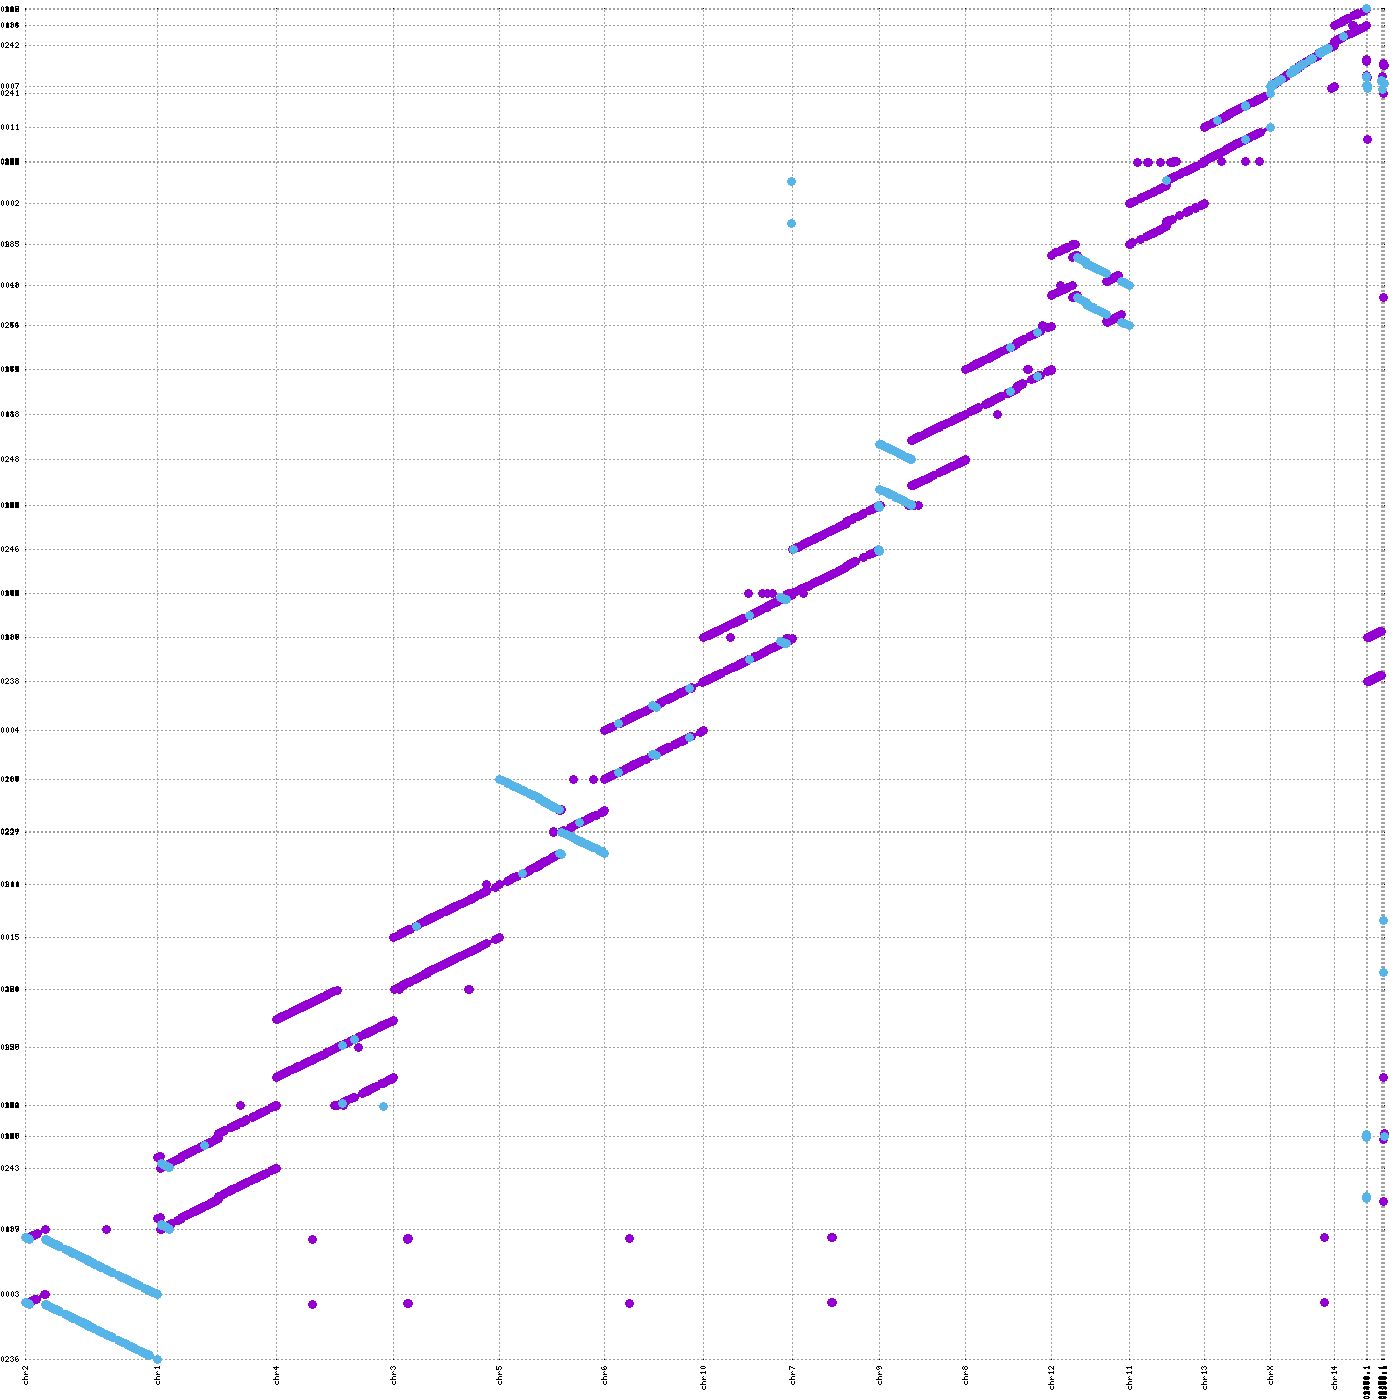

In [28]:
vf.tl.showPairwiseAlign(obj, size="large")

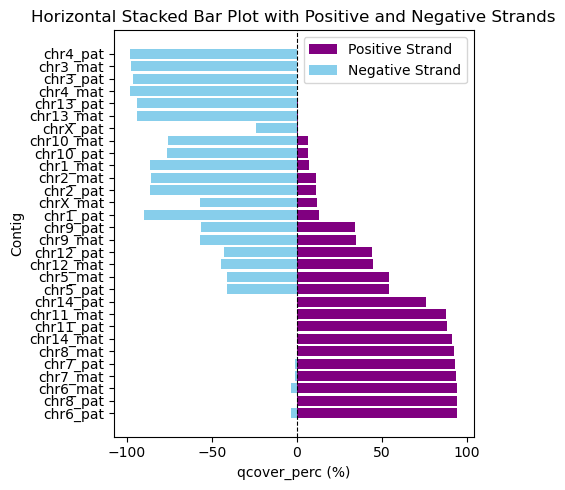

In [29]:
vf.pl.showMashmapOri(obj, plot_height = 10 , plot_width = 5)

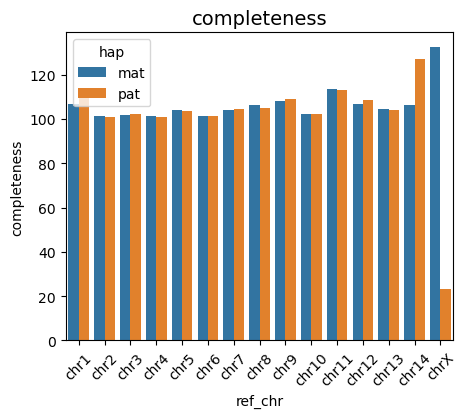

In [30]:
vf.pl.completePlot(obj, plot_height = 5 , plot_width = 10)

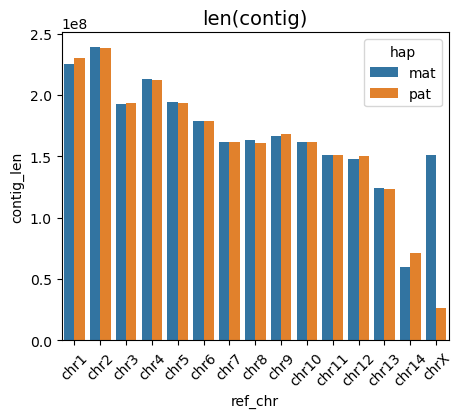

In [31]:
vf.pl.contigLenPlot(obj,plot_height = 5 , plot_width = 10)

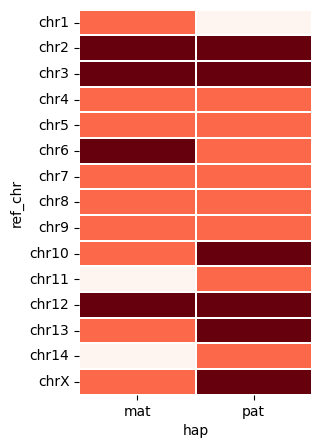

In [32]:
vf.pl.contigPlot(obj,plot_height = 8 , plot_width = 2)

- **red brown(#5E0E12)**: Contig (complete T2T without gaps)  
- **Salmon Color(#E97254)**: Scaffold (T2T with gaps or tangles)
- **Beige(#FDF5F1)** : Not a scaffold (missing one of the telomere)


## Lets fillet the verkko assembly!

Verkko is a very powerful tool for assembling long-read data to generate a complete diploid assembly, but it still has some limitations, such as generating gaps, tangles, missing telomeres, and more. These issues can occur due to sequencing errors, lower sample quality, or overly complex or homogeneous sequences, which are difficult to assemble. As a result, some manual inspection is needed. Below, we classify the scenarios that can lead to gaps in the assembly and their potential solutions.

**1. Missing Telomeres**

- **Broken Contig**: This can occur when large tangles or gaps exist in the middle of a contig, causing Rukki to split the contig. This can be resolved by connecting the contigs with a gap in the Rukki path.
  
- **Internal Telomere Sequencing**: In this case, additional sequences are added after the telomere, preventing the `getT2T` function from detecting the telomere and reporting the contig as a scaffold, even if it contains an internal telomere. This issue might arise due to ONT sequencing bias and can be fixed by trimming the sequences before the internal telomere after identifying its start position.

- **Missing Sequence at the End**: If you see isolated telomere-attached nodes, you can find homologous nodes to determine the counterpart of the haplotype on the chromosome and stitch them together by inserting a gap.

**2. Gaps, Bubbles, and Tangles**

- **rDNA**: The number of rDNA arrays and their morphs vary by species, and rDNA sequences are too similar to be assembled automatically. We recommend running `ribotin` to find the consensus of the rDNA sequences and patch the assembly with the rDNA consensus.

- **Complex Tangles**: Sometimes, Hifiasm can generate longer contigs that cover tangles in the Verkko assembly. We can use the HiFi assembly to align it on the Verkko graph and get hints from the alignment to resolve the walk on the nodes.

- **Simple Tangles or Bubbles**: In this scenario, ONT alignments on the Verkko graph using `graphaligner` can be helpful. Searching for supported paths that connect nodes in the gap can help resolve simple tangles.

- **Edge Missing**: If your assembly has missing edges between two nodes, this might be due to too few supported ONT reads (<3) connecting the nodes. We can find the supported split ONT reads aligned on nearby nodes and add the edge to the graph.

- **Loops**: Repeated sequences with multiple copies can be problematic to assemble, especially when the repeat is long enough to span ONT reads at both ends of the flanking nodes. In this case, we edit the gaps with the estimated number of loops and fill the gaps with semi-filled gaps.

**3. Haplotype Unassignment**

- **One Haplotypes is Ambiguous**: This scenario occurs when heterozygous nodes flank long runs of homozygous nodes, making Verkko unsure which haplotype should be assigned. If we have evidence that the other haplotype has already been assigned to one of the nodes in the gap, we can assign the other haplotype to the ambiguous node.

- **Both Haplotypes are Ambiguous**: When both haplotypes have gaps in a bubble, there’s no way to determine the correct haplotype for the gap. In this case, we will randomly assign the haplotypes. This can be corrected during the polishing step later.


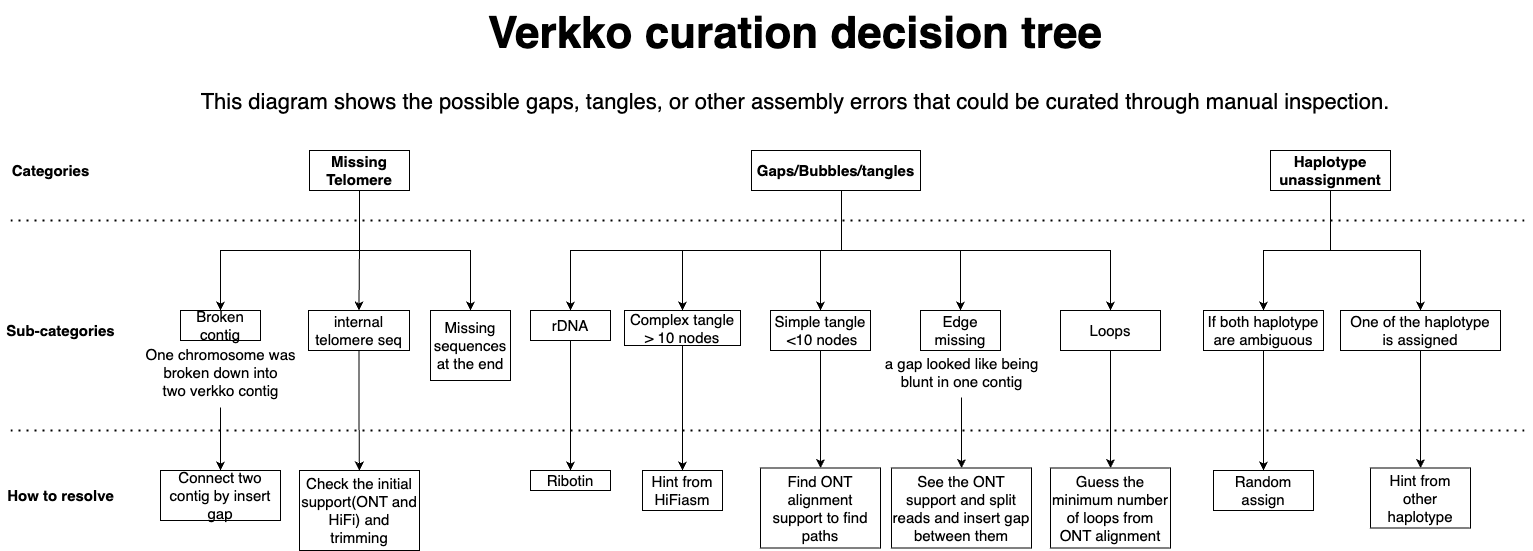

In [43]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/verkko_curation_decision_tree.png"
display(Image(filename=image_path,width=1500, height = 500))

## Missing Telomere

### 3. Internal telomere sequencing detection

Sometimes, additional sequences are added to the end of a contig beyond the telomere. As a result, the `vf.tl.getT2T` function classifies them as not scaffolds because it cannot detect telomere sequences at the end of the contig.

To check if your assembly has this kind of issue, you can use the following functions:

- `vf.tl.run_intra_telo()`: Finds all telomere sequences at the whole-genome level.
- `vf.pp.find_intra_telo()`: Helps identify which contigs contain internal telomere sequences.

You can trim these sequences later, after running the final Verkko consensus step.

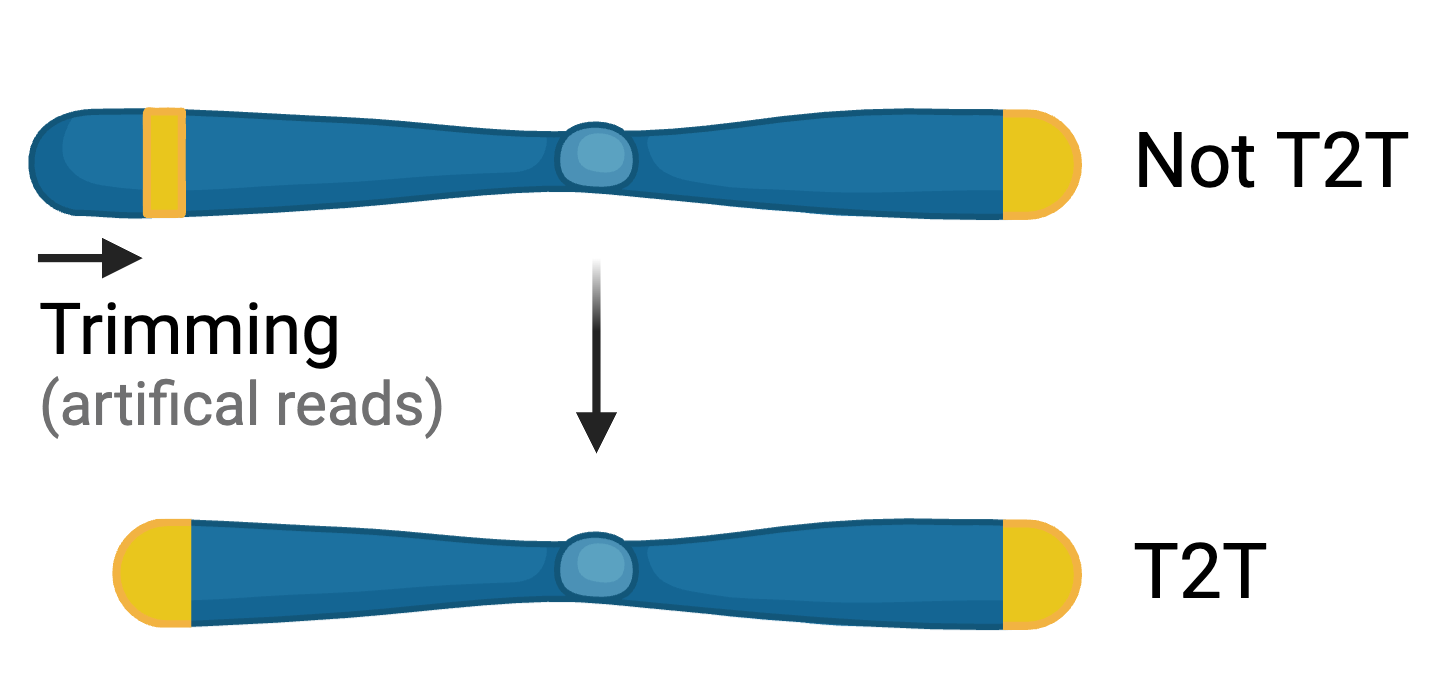

In [44]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/detect_intra_tel.png"
display(Image(filename=image_path,width=500))

For telomere detection, we use scripts and pipelines from the VGP project. You can download the scripts from the [VGP GitHub repository](https://github.com/VGP/vgp-assembly)

In [ ]:
vf.tl.detect_internal_telomere(obj)

In [128]:
vf.pp.find_intra_telo(obj, loc_from_end=25000)

contig     old_chr ref_chr  hap      start  \
0  sire_compressed.k31.hapmer-0000243  CM029949.1    chr1  pat  117570000   
1   dam_compressed.k31.hapmer-0000008  CM029962.1   chr14  mat   59943600   

         end    len_fai  
0  117607600  117607670  
1   59964200   59964298

The `dam_compressed.k31.hapmer-0000002` contig (chr11 mat) was reported as a scaffold (see the `vf.pl.contigPlot(obj)` plot) because the start telomere begins inside the telomeric region (18,800 bp from the first base at one end). This caused `getT2T` to miss it. We will trim this contig after running Verkko-consensus to finalize the assembly and fix the issue.


## Gaps / Bubbles / Tangles

### Finding gaps from path

Using the Rukki final paths that are already loaded in the object, we can retrieve the gaps with flanking nodes and the names of the contigs using the `vf.pp.findGaps` function. This function will store the list of gaps in the `obj.gaps` attribute, and you can access the table.


In [48]:
obj

FilletObj
  verkkoDir: /path/to/verkko_result_directory
  verkko_fillet_dir: /path/to/verkko_result_directory_verkko_fillet
  paths: name, path, assignment
  stats: contig, ref_chr, contig_len, ref_chr_len, hap, old_chr, completeness, hap_verkko, t2tStat
  qv: asmName, nKmer_uniq_asm, nKmer_total, QV, ErrorRate
  history: timestamp, activity, function

In [49]:
%%time
obj = vf.pp.findGaps(obj)

45 gaps were found -> obj.gaps
CPU times: user 74.9 ms, sys: 864 µs, total: 75.8 ms
Wall time: 75.3 ms


In [50]:
print(obj)

FilletObj
  verkkoDir: /path/to/verkko_result_directory
  verkko_fillet_dir: /path/to/verkko_result_directory_verkko_fillet
  paths: name, path, assignment, gaps
  stats: contig, ref_chr, contig_len, ref_chr_len, hap, old_chr, completeness, hap_verkko, t2tStat
  gaps: gapId, name, gaps, notes, fixedPath, startMatch, endMatch, finalGaf, done
  qv: asmName, nKmer_uniq_asm, nKmer_total, QV, ErrorRate
  history: timestamp, activity, function



The first three columns are generated from the Rukki path, and the others are the columns we will fill during gap filling. The `gaps` column contains each gap along with the flanking nodes, allowing you to easily visualize how the gaps or bubbles look using the flanking nodes in Bandage.


In [51]:
obj.gaps

gapId                                        name  \
0   gapid_0   dam_compressed.k31.hapmer_from_utig4-1003   
0   gapid_1   dam_compressed.k31.hapmer_from_utig4-1104   
1   gapid_2   dam_compressed.k31.hapmer_from_utig4-1104   
2   gapid_3   dam_compressed.k31.hapmer_from_utig4-1104   
3   gapid_4   dam_compressed.k31.hapmer_from_utig4-1104   
0   gapid_5   dam_compressed.k31.hapmer_from_utig4-1315   
0   gapid_6   dam_compressed.k31.hapmer_from_utig4-1425   
0   gapid_7   dam_compressed.k31.hapmer_from_utig4-1629   
1   gapid_8   dam_compressed.k31.hapmer_from_utig4-1629   
2   gapid_9   dam_compressed.k31.hapmer_from_utig4-1629   
0  gapid_10   dam_compressed.k31.hapmer_from_utig4-1730   
1  gapid_11   dam_compressed.k31.hapmer_from_utig4-1730   
0  gapid_12   dam_compressed.k31.hapmer_from_utig4-1860   
1  gapid_13   dam_compressed.k31.hapmer_from_utig4-1860   
2  gapid_14   dam_compressed.k31.hapmer_from_utig4-1860   
3  gapid_15   dam_compressed.k31.hapmer_from_utig4-1860   
4  gapid_16   dam_compressed.k31.hapmer_from_utig4-1860   
5  gapid_17   dam_compressed.k31.hapmer_from_utig4-1860   
0  gapid_18   dam_compressed.k31.hapmer_from_utig4-2349   
0  gapid_19    dam_compressed.k31.hapmer_from_utig4-409   
0  gapid_20    dam_compressed.k31.hapmer_from_utig4-458   
0  gapid_21    dam_compressed.k31.hapmer_from_utig4-558   
0  gapid_22  sire_compressed.k31.hapmer_from_utig4-1004   
0  gapid_23  sire_compressed.k31.hapmer_from_utig4-1105   
1  gapid_24  sire_compressed.k31.hapmer_from_utig4-1105   
0  gapid_25  sire_compressed.k31.hapmer_from_utig4-1283   
1  gapid_26  sire_compressed.k31.hapmer_from_utig4-1283   
0  gapid_27  sire_compressed.k31.hapmer_from_utig4-1426   
1  gapid_28  sire_compressed.k31.hapmer_from_utig4-1426   
2  gapid_29  sire_compressed.k31.hapmer_from_utig4-1426   
3  gapid_30  sire_compressed.k31.hapmer_from_utig4-1426   
0  gapid_31  sire_compressed.k31.hapmer_from_utig4-1445   
1  gapid_32  sire_compressed.k31.hapmer_from_utig4-1445   
2  gapid_33  sire_compressed.k31.hapmer_from_utig4-1445   
0  gapid_34  sire_compressed.k31.hapmer_from_utig4-1714   
1  gapid_35  sire_compressed.k31.hapmer_from_utig4-1714   
0  gapid_36  sire_compressed.k31.hapmer_from_utig4-1859   
0  gapid_37   sire_compressed.k31.hapmer_from_utig4-408   
1  gapid_38   sire_compressed.k31.hapmer_from_utig4-408   
0  gapid_39   sire_compressed.k31.hapmer_from_utig4-457   
1  gapid_40   sire_compressed.k31.hapmer_from_utig4-457   
2  gapid_41   sire_compressed.k31.hapmer_from_utig4-457   
3  gapid_42   sire_compressed.k31.hapmer_from_utig4-457   
0  gapid_43   sire_compressed.k31.hapmer_from_utig4-557   
1  gapid_44   sire_compressed.k31.hapmer_from_utig4-557   

                                                gaps notes fixedPath  \
0    [utig4-2639+, [N5000N:ambig_path], utig4-2652+]                   
0         [utig4-70+, [N212780N:tangle], utig4-100+]                   
1     [utig4-100+, [N5000N:ambig_path], utig4-2421+]                   
2    [utig4-1130-, [N5000N:ambig_path], utig4-1082+]                   
3     [utig4-370+, [N100000N:scaffold], utig4-2178+]                   
0    [utig4-1957+, [N5000N:ambig_path], utig4-2581-]                   
0   [utig4-2613+, [N1000N:ambig_bubble], utig4-626-]                   
0    [utig4-2667-, [N5000N:ambig_path], utig4-2665+]                   
1  [utig4-2668+, [N1000N:ambig_bubble], utig4-2656+]                   
2      [utig4-1748-, [N184173N:tangle], utig4-1999+]                   
0        [utig4-210-, [N572862N:tangle], utig4-151-]                   
1       [utig4-151-, [N685960N:tangle], utig4-1730+]                   
0    [utig4-1446+, [N5000N:ambig_path], utig4-1736+]                   
1   [utig4-1736+, [N1000N:ambig_bubble], utig4-617-]                   
2  [utig4-617-, [N10166N:ambig_bubble], utig4-2543-]                   
3   [utig4-2543-, [N1000N:ambig_bubble], utig4-255-]                   
4   [utig4-255-, [N44532N:ambig_bubble], utig4-529+]               

### Align ONT Reads onto the graph

All ONT datasets used during the Verkko assembly are stored in the Verkko output directory. We use the ONT reads and align them to the Verkko graph using `graphAligner`. This alignment helps us create reasonable paths through the gaps and bubbles. In future versions of Verkko, this step will be integrated into the assembly process.

`vf.tl.graphIdx()` will index the `assembly.homopolymer-compressed.gfa` graph, and `vf.tl.graphAlign()` uses the ONT reads under the `3-align/split` directory. The output `GAF` file will be saved to the `9-graphAlignment/verkko.graphAlign_allONT.gaf`.


In [ ]:
vf.tl.graphIdx(obj,threads=1)

`ont.list` is a file containing a single column of `ont.fastq` or `ont.fasta` filenames. By default, this is set to `None`. If not provided, the script will search for the ONT file list used during the Verkko assembly, located under the `3-align/split/` directory in the original Verkko directory.

In [ ]:
vf.tl.graphAlign(obj = obj, threads=50, ontReadList = "ont.list")

In [53]:
obj = vf.pp.readGaf(obj)

Looking for GAF file at: /path/to/verkko_result_directory_verkko_fillet/graphAlignment/verkko.graphAlign_allONT.gaf
Loading ONT alignment GAF file...
GAF file successfully loaded.


In [54]:
obj

FilletObj
  verkkoDir: /path/to/verkko_result_directory
  verkko_fillet_dir: /path/to/verkko_result_directory_verkko_fillet
  paths: name, path, assignment, gaps
  stats: contig, ref_chr, contig_len, ref_chr_len, hap, old_chr, completeness, hap_verkko, t2tStat
  gaps: gapId, name, gaps, notes, fixedPath, startMatch, endMatch, finalGaf, done
  gaf: Qname, len, path, mapQ, identity, path_modi
  qv: asmName, nKmer_uniq_asm, nKmer_total, QV, ErrorRate
  history: timestamp, activity, function

In [55]:
obj.gaf.head(2)

Qname    len         path  mapQ  identity  \
0  44d9663c-0eca-4b65-979f-c764a37bec99  28298  <utig4-1629    60  0.995868   
1  ee68118a-03ad-47d1-8970-6e0fe958c1f9  29563  >utig4-1222    60  0.994661   

      path_modi  
0  @utig4-1629@  
1  @utig4-1222@

### Searching the nodes in the ONT alignment GAF file. 

Once you have loaded the ONT alignment into your Verkko Fillet object, you can search using two nodes to view the number of paths that span both nodes using the `vf.pp.searchNodes` function. The output will have 4 columns:

1. **path**: The ONT alignment path.  
2. **size**: The number of supported reads for the path.  
3. **node1**: `Y` if the path spans node1.  
4. **node2**: `Y` if the path spans node2.


In [56]:
%%time
node_list_input = ['utig4-317', 'utig4-2181']
vf.pp.searchNodes(obj, node_list_input)

Path frequency is empty, generating `obj.paths_freq`.
Extracting paths containing nodes: ['utig4-317', 'utig4-2181']
CPU times: user 910 ms, sys: 76.7 ms, total: 986 ms
Wall time: 1.15 s


path,size,@utig4-317@,@utig4-2181@
>utig4-317<utig4-2324<utig4-2181,2,Y,Y
>utig4-317,13920,Y,
<utig4-317,13589,Y,
<utig4-2181,779,,Y
>utig4-2181,658,,Y
<utig4-317>utig4-316,93,Y,
<utig4-2181>utig4-2180,90,,Y
<utig4-2324<utig4-2181,88,,Y
<utig4-316>utig4-317,88,Y,
<utig4-2180>utig4-2181,87,,Y


### 3. Simple Tangles or Bubbles

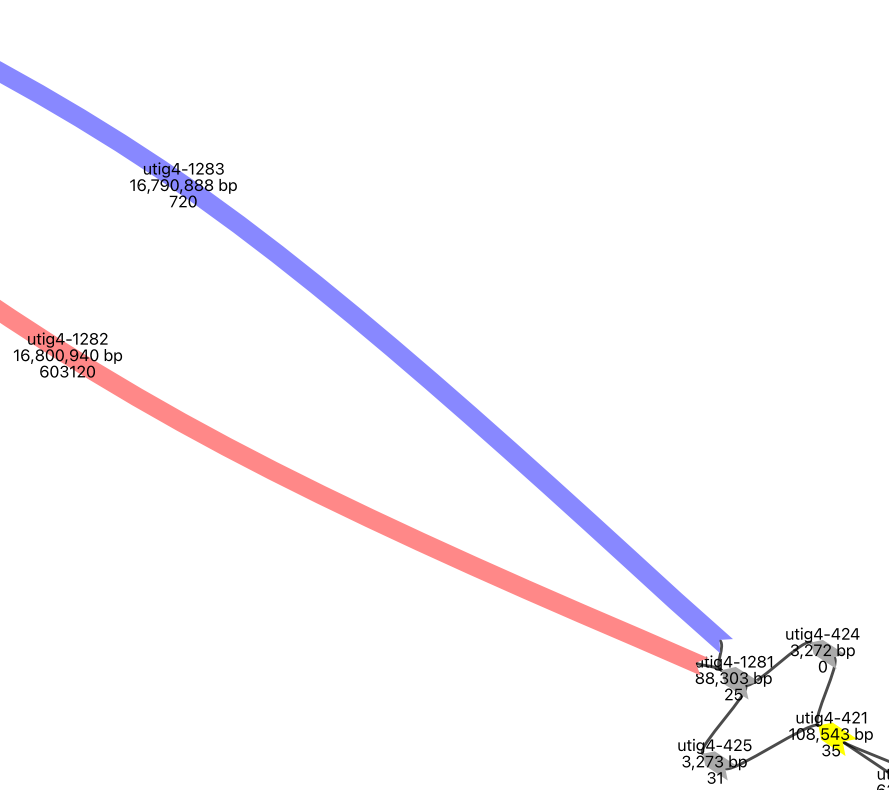

In [58]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/unit18.png"
display(Image(filename=image_path,width=500, height = 500))

In [59]:
%%time
node_list_input = ['utig4-424', 'utig4-1283']
vf.pp.searchNodes(obj, node_list_input)

`obj.paths_freq` already exists.
Extracting paths containing nodes: ['utig4-424', 'utig4-1283']
CPU times: user 8.57 ms, sys: 52 µs, total: 8.62 ms
Wall time: 8.07 ms


path,size,@utig4-424@,@utig4-1283@
<utig4-1283<utig4-1281<utig4-424<utig4-421,1,Y,Y
<utig4-1283,49416,,Y
>utig4-1283,49028,,Y
<utig4-2456<utig4-1283,89,,Y
<utig4-1283<utig4-1281,81,,Y
>utig4-1283>utig4-2456,76,,Y
>utig4-1281>utig4-1283,70,,Y
>utig4-421>utig4-424>utig4-1281,66,Y,
<utig4-1281<utig4-424<utig4-421,62,Y,
<utig4-424<utig4-421,7,Y,


In [60]:
vf.pp.highlight_nodes(obj, node = "utig4-1282+")

name,path
dam_compressed.k31.hapmer_from_utig4-1282,"utig4-1774-,utig4-1771-,utig4-1773+,utig4-2684+,utig4-2600-,utig4-2596-,utig4-2597+,utig4-2636-,utig4-1227-,utig4-1225-,utig4-878-,utig4-875-,utig4-877+,utig4-2373+,utig4-2374+,utig4-2452-,utig4-692-,utig4-688+,utig4-693+,utig4-1779+,utig4-1781+,utig4-2402+,utig4-1978-,utig4-1974-,utig4-1976+,utig4-2502+,utig4-2018-,utig4-2017+,utig4-2020+,utig4-2676-,utig4-223-,utig4-221+,utig4-225+,utig4-1809+,utig4-1810+,utig4-2721+,utig4-1790-,utig4-1786-,utig4-1787+,utig4-1993-,utig4-1995+,utig4-2426+,utig4-2427+,utig4-2575-,utig4-721-,utig4-720-,utig4-308-,utig4-306+,utig4-309+,utig4-983+,utig4-984+,utig4-2448+,utig4-415-,utig4-413-,utig4-398-,utig4-394-,utig4-395+,utig4-2602-,utig4-1857-,utig4-1855+,utig4-949-,utig4-946-,utig4-947+,utig4-2268+,utig4-2269+,utig4-2642+,utig4-515-,utig4-512-,utig4-513+,utig4-2161+,utig4-1793-,utig4-1791+,utig4-1470-,utig4-1469-,utig4-1251-,utig4-1250+,utig4-1253+,utig4-2573-,utig4-199-,utig4-197+,utig4-200+,utig4-2000+,utig4-2002+,utig4-2403+,utig4-1642-,utig4-1592-,utig4-1589+,utig4-1593+,utig4-1818-,utig4-1819+,utig4-2388+,utig4-2390+,utig4-2490-,utig4-2386-,utig4-2384+,utig4-2257-,utig4-2255-,utig4-474-,utig4-472+,utig4-475+,utig4-2363+,utig4-2327-,utig4-2325+,utig4-2328+,utig4-2650-,utig4-422-,utig4-421+,utig4-425+,utig4-1281+,utig4-1282+,utig4-2456+,utig4-1902-,utig4-1898-,utig4-1899+,utig4-2106-,utig4-2108+,utig4-2305+,utig4-2192-,utig4-2189-,utig4-2190+,utig4-2238+,utig4-1077-,utig4-1074-,utig4-1076+,utig4-2166-,utig4-1101-,utig4-1098-,utig4-1100+,utig4-2751-,utig4-2752+"


In this scenario, we find one supporting ONT alignment spanning the gap and flanking reads. However, the number of supporting reads is too small, so we also check the other haplotype paths by using the `vf.pp.highlight_nodes()` function with the counterpart nodes on the other haplotype to see if another haplotype uses the other nodes in the bubble. If so, as shown here, we can assign the node `utig-424` to the paternal strand to fill the gap.


If you have enough evidence for filling the gaps (or partially filling them), you can use this information to fill the gaps using the `vf.pp.fillGaps` function. You can easily extract the order and direction of each node using Bandage tools (Output > Specify exact path for copy/save). This information will be stored in the `obj.gaps` attribute and will be used for generating the edited Rukki path for the Verkko CNS run.

* **Caution**: Be careful to maintain the original node direction when filling the gaps.


In [64]:
%%time
obj = vf.pp.fillGaps(obj=obj,
               gapId='gapid_26',
               final_path="utig4-424+, utig4-1281+, utig4-1283+")

final path : >utig4-424>utig4-1281>utig4-1283
Updated gapId gapid_26!
 
✅ The start node and its direction match the original node.
✅ The start node and its direction match the original node.
[==                                                ] 2/45 gaps filled 
CPU times: user 2.39 ms, sys: 33 µs, total: 2.42 ms
Wall time: 2.43 ms


In [65]:
obj.history

timestamp  \
0 2025-01-23 11:10:39.664168   
1 2025-01-23 13:38:56.240400   
2 2025-01-23 13:39:27.875281   

                                            activity     function  
0  verkko-fillet obj is generated. from : /vf/use...  read_Verkko  
1  gapid_19 filled with utig4-424+, utig4-1281+, ...     fillGaps  
2  gapid_26 filled with utig4-424+, utig4-1281+, ...     fillGaps

Once you edit your path, it would be great to check the `obj.gaps` to ensure that both the `startMatch` and the `endMatch` are set to "match." The `vf.pp.fillGaps()` function also provides this information when you edit the path. These two pieces of information not only indicate the starting and ending nodes but also account for the direction of the nodes. If you provide reverted nodes, each field will be filled with "notMatch." If this is unintentional, it should be corrected before completing the gap-filling process.


Here, we show how the `vf.pp.fillGaps()` function reports when we provide wrong directions for the end nodes.


In [66]:
%%time
obj = vf.pp.fillGaps(obj=obj,
               gapId='gapid_26',
               final_path="utig4-424+, utig4-1281+, utig4-1283-")

final path : >utig4-424>utig4-1281<utig4-1283
Updated gapId gapid_26!
 
✅ The start node and its direction match the original node.
❌ The start node and its direction do not match the original node.
[==                                                ] 2/45 gaps filled 
CPU times: user 2.4 ms, sys: 0 ns, total: 2.4 ms
Wall time: 2.41 ms


It says that the start node and its direction match, but the end node does not match.


If you want to modify the gap information you have already added, simply use the same function to overwrite it. Additionally, if you want to reset the gap information, set `final_path=""` in `vf.pp.fillGaps`.


In [67]:
%%time
obj = vf.pp.fillGaps(obj=obj,
               gapId='gapid_26',
               final_path="utig4-424+, utig4-1281+, utig4-1283+")

final path : >utig4-424>utig4-1281>utig4-1283
Updated gapId gapid_26!
 
✅ The start node and its direction match the original node.
✅ The start node and its direction match the original node.
[==                                                ] 2/45 gaps filled 
CPU times: user 2.4 ms, sys: 0 ns, total: 2.4 ms
Wall time: 2.41 ms


### 4. Edge Missing

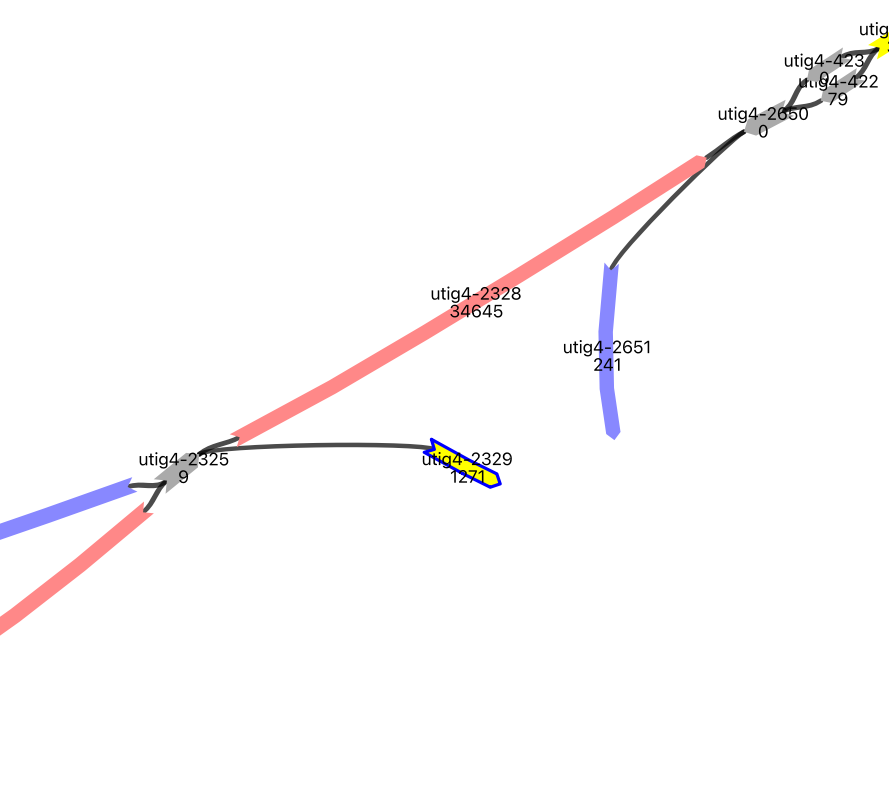

In [68]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/unit17.png"
display(Image(filename=image_path,width=500, height = 500))

The `vf.pp.searchSplit` function will find the split reads that are aligned to two nodes that are not connected.


In [94]:
%%time
node_list_input = ["utig4-2329","utig4-2651"]
splitreads = vf.pp.searchSplit(obj,node_list_input)
splitreads

CPU times: user 3.43 s, sys: 116 ms, total: 3.55 s
Wall time: 3.56 s


Qname                     path_modi
474   378e4ed7-87e4-4b42-b86e-fbdfcd2c7c38  {@utig4-2329@, @utig4-2651@}
611   47cff639-2a5a-4466-83a4-922ffc3182df  {@utig4-2329@, @utig4-2651@}
827   5cc4bd3c-f6de-46d9-b024-883b7043eb46  {@utig4-2329@, @utig4-2651@}
911   65ee6dbe-fe77-4e1e-b0e2-f1752d80440b  {@utig4-2329@, @utig4-2651@}
1152  826f54d8-c67b-47b4-807d-d51ebb0b84ee  {@utig4-2329@, @utig4-2651@}
1567  b4c86418-bc2d-43ab-bcc5-61a06f0ef3f2  {@utig4-2329@, @utig4-2651@}
1949  e0a27314-9326-4f71-97c5-3d6c9e25c3e1  {@utig4-2329@, @utig4-2651@}
2128  f5fee93e-b93e-43fa-a8df-322f274082e5  {@utig4-2329@, @utig4-2651@}

In [125]:
vf.tl.insertGap(obj, gapid="gapid_25", split_reads=splitreads)

Extracting reads...
The split reads for gapid_25 were saved to /path/to/verkko_result_directory_verkko_fillet/missing_edge/gapid_25.missing_edge.ont_list.txt
The gap filling was completed for gapid_25!
The final path looks like:
{'>utig4-2651<gapmanual-1-len--4567-cov-4<utig4-2329', '>utig4-2329>gapmanual-1-len--4567-cov-4<utig4-2651'}


In [127]:
%%time
obj = vf.pp.fillGaps(obj=obj,
               gapId='gapid_25',
               final_path="utig4-2329+,gapmanual-1-len--4567-cov-4+,utig4-2651-")

final path : >utig4-2329>gapmanual-1-len--4567-cov-4<utig4-2651
Updated gapId gapid_25!
 
✅ The start node and its direction match the original node.
✅ The start node and its direction match the original node.
[========                                          ] 8/45 gaps filled 
CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.66 ms


### 4. Loops

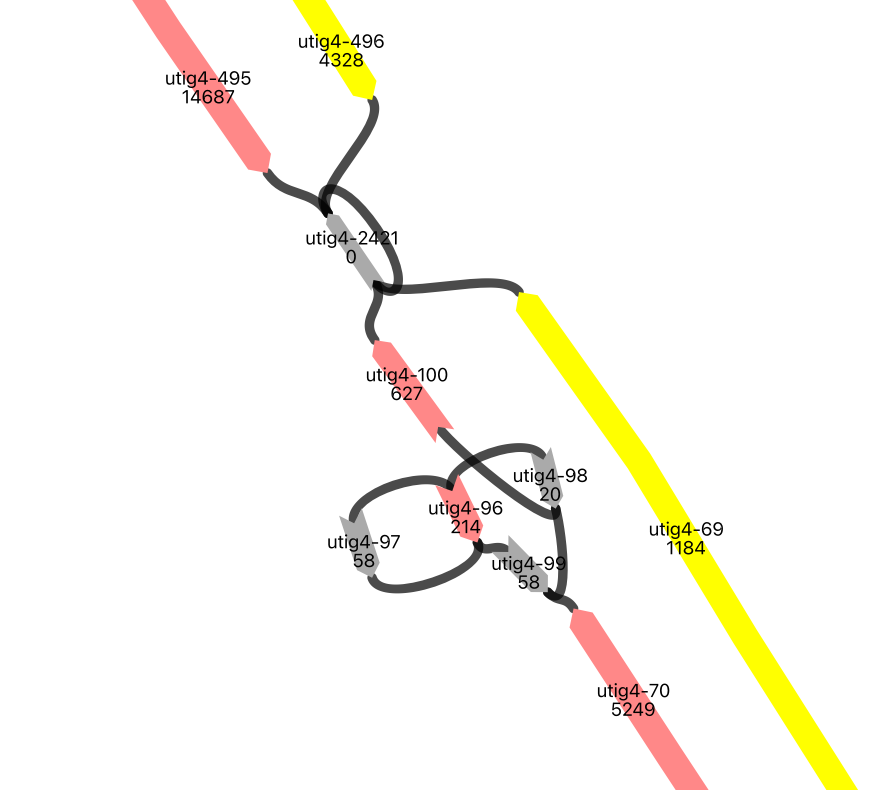

In [70]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/unit2.png"
display(Image(filename=image_path,width=500, height = 500))

This is one of the rDNA clusters in the Giraffe genome. The node `utig4-2421` has a loop, and we don't know how many times the node exists in each haplotype strand. Here, we estimate the minimum number of loops for the node on the maternal strand by finding the number of loop nodes in each ONT alignment that spans the haplotype-assigned nodes near the loop node(in this case, `utig4-100` and `utig4-495`). We then fill the gaps with the estimated number of loops, along with the flanking new gaps. This allows us to build an assembly that may not be perfect but is gradually improving. Additionally, multiple loops could enhance the read alignment in future use.


In [ ]:
%%time
vf.pp.estLoops(obj, ["utig4-100", "utig4-495"])

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


The most frequent number of loops in the ONT path spanning the loop node and the haplotype-assigned nodes is 3 for this gap. So, we fill this gap with 3 copies of the loop node, flanked by new gaps named `loop_uncertain_copy`. Additionally, for this case, we add a gap at the end of the new path, which could lead to an "unmatch" warning in the report. However, this is intentionally done, so we can ignore the warning here.


In [92]:
obj = vf.pp.fillGaps(obj=obj,
               gapId='gapid_2',
               final_path="utig4-100+, [N5000N:loop_uncertain_copy],utig4-2421+,utig4-2421+,utig4-2421+")

final path : >utig4-100[N5000N:loop_uncertain_copy]>utig4-2421>utig4-2421>utig4-2421
Updated gapId gapid_2!
 
✅ The start node and its direction match the original node.
✅ The start node and its direction match the original node.
[=======                                           ] 7/45 gaps filled 


### 6.Homologous nodes but hint from other haplotype

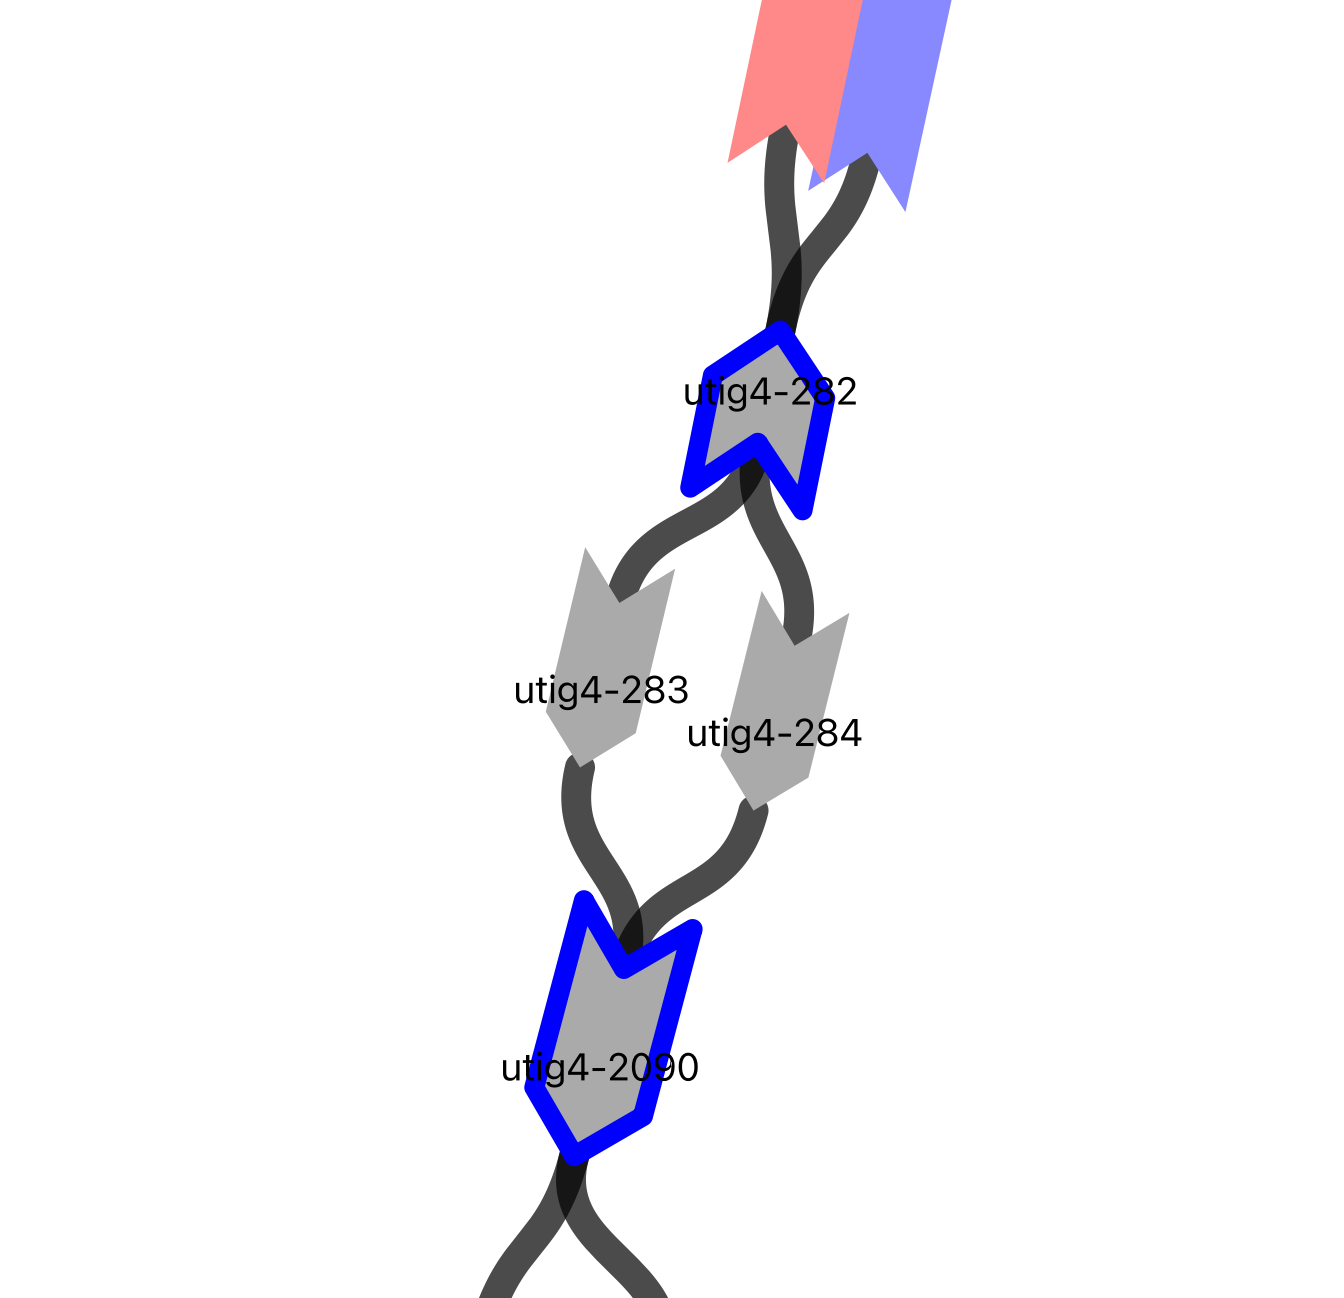

In [71]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/gapid_24.png"
display(Image(filename=image_path,width=500, height = 500))

In [73]:
%%time
node_list_input = ['utig4-282', 'utig4-2090']
vf.pp.searchNodes(obj, node_list_input)

`obj.paths_freq` already exists.
Extracting paths containing nodes: ['utig4-282', 'utig4-2090']
CPU times: user 8 ms, sys: 3 µs, total: 8 ms
Wall time: 7.46 ms


path,size,@utig4-282@,@utig4-2090@
<utig4-282>utig4-283>utig4-2090,90,Y,Y
<utig4-2090<utig4-283>utig4-282,88,Y,Y
<utig4-2090<utig4-284>utig4-282,85,Y,Y
<utig4-282>utig4-284>utig4-2090,82,Y,Y
<utig4-2090,1792,,Y
>utig4-2090,1773,,Y
>utig4-282,559,Y,
<utig4-282,543,Y,
<utig4-285<utig4-282,101,Y,
<utig4-286<utig4-282,94,Y,


Here, we can identify two clear paths: `<utig4-282>utig4-283>utig4-2090` and `<utig4-282>utig4-284>utig4-2090`. However, we are unable to determine the haplotype using ONT alignment. In such cases, one of the obvious paths might already be used by another haplotype. Thus, we can assign the haplotype harboring this gap to the other obvious path, using an elimination method.


In [74]:
vf.pp.highlight_nodes(obj, node = "utig4-282-")

name,path
dam_compressed.k31.hapmer_from_utig4-458,"utig4-2548+,utig4-2550+,utig4-2661-,utig4-917-,utig4-913-,utig4-914+,utig4-1121-,utig4-1123+,utig4-2641-,utig4-1381-,utig4-1379+,utig4-1383+,utig4-2677-,utig4-2586-,utig4-2584-,utig4-2484-,utig4-2482-,utig4-2027-,utig4-2023-,utig4-2024+,utig4-2601+,utig4-286-,utig4-282-,utig4-283+,utig4-2090+,utig4-810-,utig4-808+,utig4-811+,utig4-2691+,utig4-354-,utig4-353+,utig4-356+,utig4-1350-,utig4-1318-,utig4-1317+,utig4-1319+,utig4-2617+,utig4-868-,utig4-865-,utig4-289-,utig4-287+,utig4-1097+,utig4-841-,utig4-839+,utig4-52-,utig4-51+,utig4-55+,utig4-1979-,utig4-455-,utig4-454+,utig4-458+,utig4-1300-,utig4-1301+,utig4-2170+,utig4-1372-,utig4-1371+,utig4-1374+,utig4-2262-,utig4-1947-,utig4-1943-,utig4-1944+,utig4-2512-,utig4-2513+,utig4-2515+,utig4-2612-,utig4-2610-,utig4-2608+,[N5000N:ambig_path],utig4-2527-,utig4-1013-,utig4-1010-,utig4-1011+,utig4-1263-,utig4-1264+,utig4-2622+,utig4-2472-,utig4-2471+,utig4-1449-,utig4-1447+,utig4-1450+,utig4-2186-,utig4-1972-,utig4-1971-,utig4-1968-,utig4-471-,utig4-467-,utig4-468+,utig4-887+,utig4-889+,utig4-2438-,utig4-2439+,utig4-2469+,utig4-2199-,utig4-2198+,utig4-2203+,utig4-2251-,utig4-1668-,utig4-1667+,utig4-1670+,utig4-1868+,utig4-804-,utig4-800-,utig4-801+,utig4-885+,utig4-886+,utig4-768-,utig4-765-,utig4-767+,utig4-2122-,utig4-2123+,utig4-2366+,utig4-351-,utig4-348-,utig4-349+,utig4-2621+,utig4-1187-,utig4-1186+,utig4-1189+,utig4-2077-,utig4-1140-,utig4-1139+,utig4-1093-,utig4-1089-,utig4-1090+,utig4-1389+,utig4-1390+,utig4-2008-,utig4-29-,utig4-27+,utig4-30+,utig4-823+,utig4-824+"
sire_compressed.k31.hapmer_from_utig4-457,"utig4-2548+,utig4-2549+,utig4-2661-,utig4-916-,utig4-913-,utig4-915+,utig4-1121-,utig4-1122+,utig4-2641-,utig4-1380-,utig4-1379+,utig4-1382+,utig4-2677-,utig4-2585-,utig4-2584-,utig4-2483-,utig4-2482-,utig4-2026-,utig4-2023-,utig4-2025+,utig4-2601+,utig4-285-,utig4-282-,[N5000N:ambig_path],utig4-2090+,utig4-809-,utig4-808+,utig4-812+,utig4-2691+,utig4-355-,utig4-353+,utig4-357+,utig4-1350-,utig4-1351+,[N5000N:ambig_path],utig4-6+,utig4-14+,utig4-1317+,utig4-1320+,utig4-2617+,utig4-867-,utig4-865-,utig4-866+,utig4-869+,utig4-1097+,utig4-840-,utig4-839+,utig4-53-,utig4-51+,utig4-54+,utig4-1979-,utig4-456-,utig4-454+,utig4-457+,utig4-1300-,utig4-1302+,utig4-2170+,utig4-1373-,utig4-1371+,utig4-1375+,utig4-2262-,utig4-1946-,utig4-1943-,utig4-1945+,utig4-2512-,utig4-2514+,utig4-40-,[N5000N:ambig_path],utig4-39+,[N1000N:ambig_bubble],utig4-119-,utig4-120+,utig4-1010-,utig4-1012+,utig4-1263-,utig4-1265+,utig4-2622+,utig4-2473-,utig4-2471+,utig4-1448-,utig4-1447+,utig4-1451+,utig4-2186-,utig4-2187+,utig4-1969-,utig4-1968-,utig4-470-,utig4-467-,utig4-469+,utig4-887+,utig4-888+,utig4-2438-,utig4-2440+,utig4-2469+,utig4-2199-,utig4-2198+,utig4-2202+,utig4-2251-,utig4-1669-,utig4-1667+,utig4-1671+,utig4-1868+,utig4-803-,utig4-800-,utig4-802+,utig4-885+,utig4-511-,utig4-509+,utig4-765-,utig4-766+,utig4-2122-,utig4-2124+,utig4-2366+,utig4-352-,utig4-348-,utig4-350+,utig4-2621+,utig4-1188-,utig4-1186+,utig4-1190+,utig4-1191+,utig4-2078-,utig4-2077-,utig4-1141-,utig4-1139+,utig4-1092-,utig4-1089-,utig4-1091+,utig4-1389+,utig4-1391+,utig4-2008-,utig4-28-,utig4-27+,utig4-31+,utig4-823+,utig4-825+"


When we search for the `utig4-282-` node in the paths, the maternal (dam) strand has already used the `utig4-283+` node. Therefore, we can use the `utig4-284+` node to fill the gap on the paternal (sire) strand.


In [76]:
obj = vf.pp.fillGaps(obj=obj,
               gapId='gapid_39',
               final_path="utig4-282-, utig4-284+, utig4-2090+")

final path : <utig4-282>utig4-284>utig4-2090
Updated gapId gapid_39!
 
✅ The start node and its direction match the original node.
✅ The start node and its direction match the original node.
[===                                               ] 3/45 gaps filled 


### 7. Homologous without hint

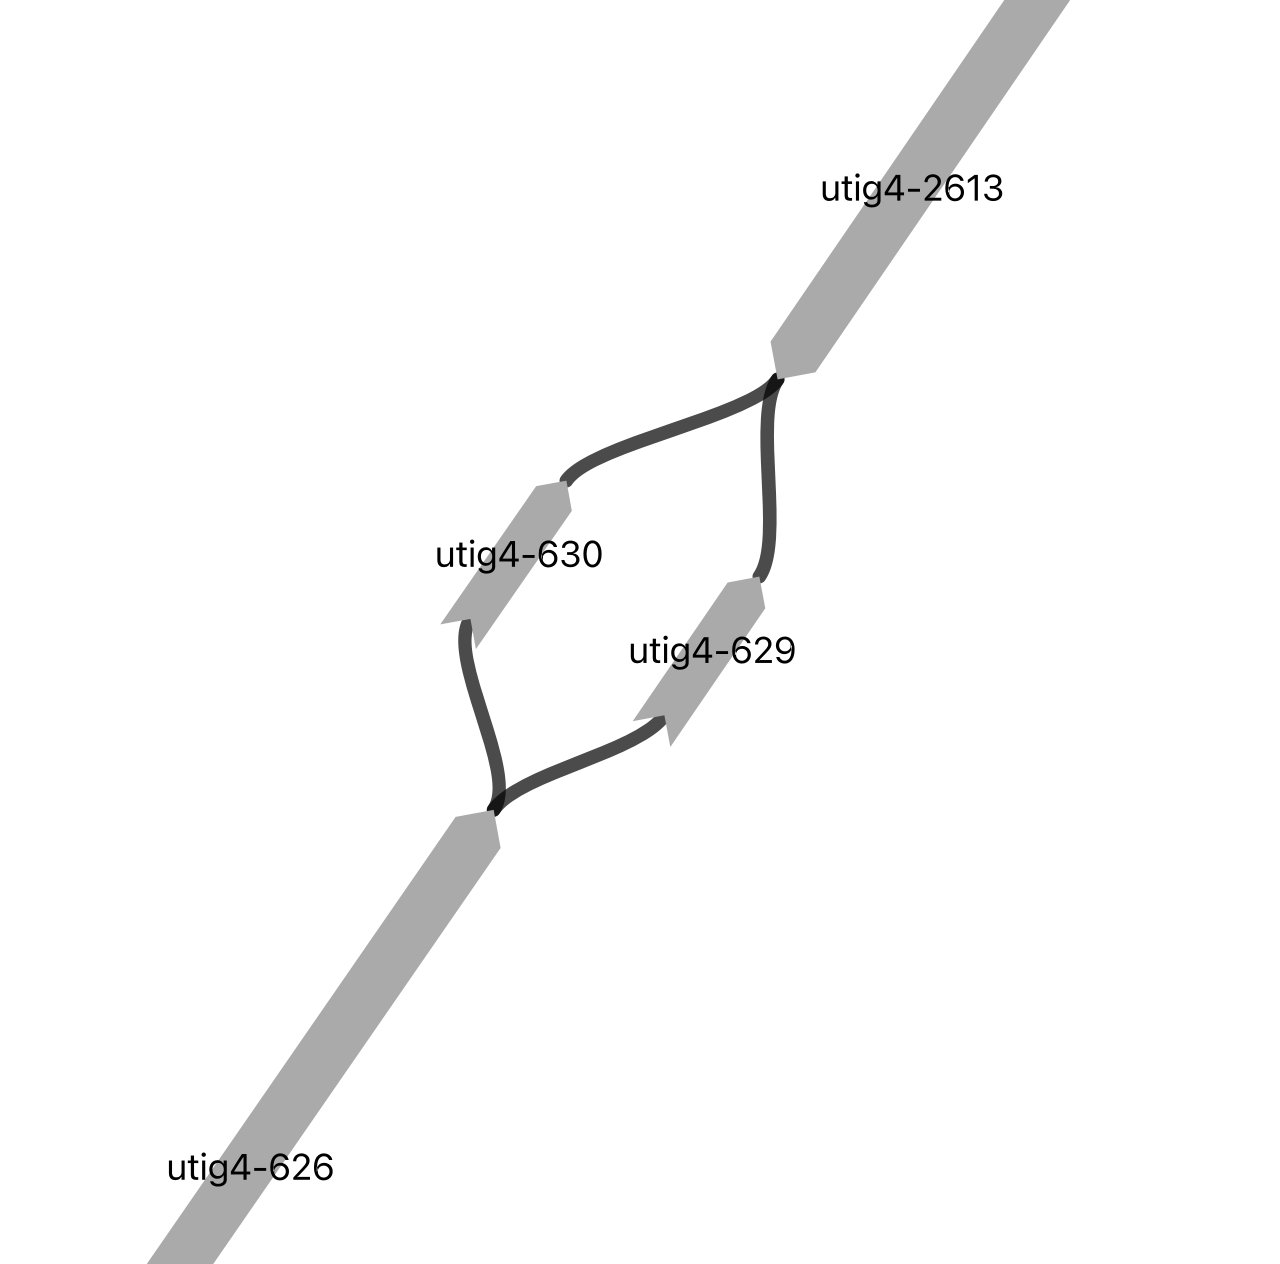

In [72]:
image_path = os.path.dirname(vf.__file__) + "/data/test_giraffe/fig/gapid_10.png"
display(Image(filename=image_path,width=500, height = 500))

In [77]:
%%time
node_list_input = ['utig4-2613', 'utig4-626']
vf.pp.searchNodes(obj, node_list_input)

`obj.paths_freq` already exists.
Extracting paths containing nodes: ['utig4-2613', 'utig4-626']
CPU times: user 7.44 ms, sys: 955 µs, total: 8.4 ms
Wall time: 8.07 ms


path,size,@utig4-2613@,@utig4-626@
>utig4-626>utig4-629<utig4-2613,108,Y,Y
>utig4-2613<utig4-629<utig4-626,101,Y,Y
>utig4-2613<utig4-630<utig4-626,57,Y,Y
>utig4-626>utig4-630<utig4-2613,53,Y,Y
<utig4-626,5187,,Y
>utig4-626,5173,,Y
>utig4-2613,2813,Y,
<utig4-2613,2752,Y,
>utig4-612>utig4-616>utig4-2613,112,Y,
<utig4-2613<utig4-615<utig4-612,86,Y,


In [78]:
vf.pp.highlight_nodes(obj, node = "utig4-2613+")

name,path
dam_compressed.k31.hapmer_from_utig4-1425,"utig4-857-,utig4-854-,utig4-851-,utig4-853+,utig4-2710+,utig4-2454-,utig4-2453-,utig4-59-,utig4-58+,utig4-62+,utig4-2589-,utig4-1175-,utig4-1173-,utig4-613-,utig4-612+,utig4-616+,utig4-2613+,[N1000N:ambig_bubble],utig4-626-,utig4-627+,utig4-2521-,utig4-534-,utig4-303-,utig4-301+,utig4-305+,utig4-669-,utig4-671+,utig4-928-,utig4-929+,utig4-2675+,utig4-1922-,utig4-1920+,utig4-73-,utig4-71+,utig4-74+,utig4-1424-,utig4-1425+,utig4-1845-,utig4-1847+,utig4-2685-,utig4-1587-,utig4-1584-,utig4-1585+,utig4-2457-,utig4-2050-,utig4-2049+,utig4-2052+,utig4-2291-,utig4-1197-,utig4-1193-,utig4-1195+,utig4-2194+,utig4-1865-,utig4-1863+,utig4-1867+,utig4-2382-,utig4-589-,utig4-587+,utig4-591+,utig4-1247+,utig4-1248+,utig4-2016+,utig4-1357-,utig4-1355+,utig4-1358+,utig4-2383-,utig4-2241-,utig4-2239-,utig4-1420-,utig4-1416-,utig4-1417+,utig4-1762+,utig4-1764+,utig4-2554-,utig4-2553-,utig4-2551+,utig4-1767-,utig4-1765+,utig4-1769+,utig4-2487-,utig4-963-,utig4-962+,utig4-966+,utig4-2357-,utig4-902-,utig4-898-,utig4-899+,utig4-1675-,utig4-1677+,utig4-2225+,utig4-1653-,utig4-1651+,utig4-111-,utig4-112+,utig4-2250+,utig4-1259-,utig4-1257+,utig4-1260+,utig4-2540-,utig4-2160-,utig4-2158+,utig4-2092-,utig4-2091+,utig4-2094+,utig4-2494-,utig4-2010-,utig4-2009-,utig4-1723-,utig4-1725+,utig4-1727+,utig4-2420+,utig4-1639-,utig4-1636-,utig4-1637+,utig4-2620-,utig4-1953-,utig4-1951+,utig4-1954+,utig4-2188+,utig4-1402-,utig4-1400-"
sire_compressed.k31.hapmer_from_utig4-1426,"utig4-996-,[N34856N:tangle],utig4-856-,utig4-854-,utig4-851-,utig4-852+,utig4-2710+,utig4-2455-,utig4-2453-,utig4-60-,utig4-58+,utig4-61+,utig4-2589-,utig4-1174-,utig4-1173-,utig4-614-,utig4-612+,utig4-615+,utig4-2613+,[N1000N:ambig_bubble],utig4-626-,utig4-628+,utig4-2521-,utig4-532-,utig4-302-,utig4-301+,utig4-304+,utig4-669-,utig4-670+,utig4-928-,utig4-930+,utig4-2675+,utig4-1921-,utig4-1920+,utig4-72-,utig4-71+,utig4-75+,utig4-1424-,utig4-1426+,utig4-1845-,utig4-1846+,utig4-2685-,utig4-1588-,utig4-1584-,utig4-1586+,utig4-2457-,utig4-2051-,utig4-2049+,utig4-2053+,utig4-2291-,utig4-1196-,utig4-1193-,utig4-1194+,utig4-2194+,utig4-1864-,utig4-1863+,utig4-1866+,utig4-2382-,utig4-588-,utig4-587+,utig4-590+,utig4-1247+,utig4-1249+,utig4-2016+,utig4-1356-,utig4-1355+,utig4-1359+,utig4-2383-,utig4-2240-,utig4-2239-,utig4-1419-,utig4-1416-,utig4-1418+,[N5000N:ambig_path],utig4-1763+,utig4-2554-,utig4-2552-,utig4-2551+,utig4-1766-,utig4-1765+,utig4-1768+,utig4-2487-,utig4-964-,utig4-962+,utig4-965+,utig4-2357-,utig4-901-,utig4-898-,utig4-900+,utig4-1675-,utig4-1676+,utig4-2225+,utig4-1652-,utig4-1651+,utig4-1127-,utig4-1128+,utig4-2250+,utig4-1258-,utig4-1257+,utig4-1261+,utig4-2540-,utig4-2159-,utig4-2158+,utig4-2093-,utig4-2091+,utig4-2095+,utig4-2494-,utig4-2011-,utig4-2009-,utig4-1728-,utig4-1725+,utig4-1726+,[N5000N:ambig_path],utig4-1640-,utig4-1636-,utig4-1638+,utig4-2620-,utig4-1952-,utig4-1951+,utig4-1955+,utig4-2188+,utig4-1401-,utig4-1400-"


This scenario has the same haplotype unassignment issue as above, but there is no hint from the other haplotype. Therefore, we randomly assign the haplotype to each gap using the paths obtained from `vf.pp.searchNodes(obj, node_list_input)`. This haplotype-switching error can be corrected during the polishing step later.


In [81]:
obj = vf.pp.fillGaps(obj=obj,
               gapId='gapid_6',
               final_path="utig4-2613+, utig4-630-, utig4-626-")

final path : >utig4-2613<utig4-630<utig4-626
Updated gapId gapid_6!
 
✅ The start node and its direction match the original node.
✅ The start node and its direction match the original node.
[====                                              ] 4/45 gaps filled 


In [82]:
obj = vf.pp.fillGaps(obj=obj,
               gapId='gapid_28',
               final_path="utig4-2613+, utig4-629-, utig4-626-")

final path : >utig4-2613<utig4-629<utig4-626
Updated gapId gapid_28!
 
✅ The start node and its direction match the original node.
✅ The start node and its direction match the original node.
[=====                                             ] 5/45 gaps filled 


## Finalize paths

In [83]:
vf.pp.checkGapFilling(obj)

[=====                                             ] 5/45 gaps filled 


gapId                                        name  \
0   gapid_0   dam_compressed.k31.hapmer_from_utig4-1003   
0   gapid_1   dam_compressed.k31.hapmer_from_utig4-1104   
1   gapid_2   dam_compressed.k31.hapmer_from_utig4-1104   
2   gapid_3   dam_compressed.k31.hapmer_from_utig4-1104   
3   gapid_4   dam_compressed.k31.hapmer_from_utig4-1104   
0   gapid_5   dam_compressed.k31.hapmer_from_utig4-1315   
0   gapid_6   dam_compressed.k31.hapmer_from_utig4-1425   
0   gapid_7   dam_compressed.k31.hapmer_from_utig4-1629   
1   gapid_8   dam_compressed.k31.hapmer_from_utig4-1629   
2   gapid_9   dam_compressed.k31.hapmer_from_utig4-1629   
0  gapid_10   dam_compressed.k31.hapmer_from_utig4-1730   
1  gapid_11   dam_compressed.k31.hapmer_from_utig4-1730   
0  gapid_12   dam_compressed.k31.hapmer_from_utig4-1860   
1  gapid_13   dam_compressed.k31.hapmer_from_utig4-1860   
2  gapid_14   dam_compressed.k31.hapmer_from_utig4-1860   
3  gapid_15   dam_compressed.k31.hapmer_from_utig4-1860   
4  gapid_16   dam_compressed.k31.hapmer_from_utig4-1860   
5  gapid_17   dam_compressed.k31.hapmer_from_utig4-1860   
0  gapid_18   dam_compressed.k31.hapmer_from_utig4-2349   
0  gapid_19    dam_compressed.k31.hapmer_from_utig4-409   
0  gapid_20    dam_compressed.k31.hapmer_from_utig4-458   
0  gapid_21    dam_compressed.k31.hapmer_from_utig4-558   
0  gapid_22  sire_compressed.k31.hapmer_from_utig4-1004   
0  gapid_23  sire_compressed.k31.hapmer_from_utig4-1105   
1  gapid_24  sire_compressed.k31.hapmer_from_utig4-1105   
0  gapid_25  sire_compressed.k31.hapmer_from_utig4-1283   
1  gapid_26  sire_compressed.k31.hapmer_from_utig4-1283   
0  gapid_27  sire_compressed.k31.hapmer_from_utig4-1426   
1  gapid_28  sire_compressed.k31.hapmer_from_utig4-1426   
2  gapid_29  sire_compressed.k31.hapmer_from_utig4-1426   
3  gapid_30  sire_compressed.k31.hapmer_from_utig4-1426   
0  gapid_31  sire_compressed.k31.hapmer_from_utig4-1445   
1  gapid_32  sire_compressed.k31.hapmer_from_utig4-1445   
2  gapid_33  sire_compressed.k31.hapmer_from_utig4-1445   
0  gapid_34  sire_compressed.k31.hapmer_from_utig4-1714   
1  gapid_35  sire_compressed.k31.hapmer_from_utig4-1714   
0  gapid_36  sire_compressed.k31.hapmer_from_utig4-1859   
0  gapid_37   sire_compressed.k31.hapmer_from_utig4-408   
1  gapid_38   sire_compressed.k31.hapmer_from_utig4-408   
0  gapid_39   sire_compressed.k31.hapmer_from_utig4-457   
1  gapid_40   sire_compressed.k31.hapmer_from_utig4-457   
2  gapid_41   sire_compressed.k31.hapmer_from_utig4-457   
3  gapid_42   sire_compressed.k31.hapmer_from_utig4-457   
0  gapid_43   sire_compressed.k31.hapmer_from_utig4-557   
1  gapid_44   sire_compressed.k31.hapmer_from_utig4-557   

                                                gaps notes  \
0    [utig4-2639+, [N5000N:ambig_path], utig4-2652+]         
0         [utig4-70+, [N212780N:tangle], utig4-100+]         
1     [utig4-100+, [N5000N:ambig_path], utig4-2421+]         
2    [utig4-1130-, [N5000N:ambig_path], utig4-1082+]         
3     [utig4-370+, [N100000N:scaffold], utig4-2178+]         
0    [utig4-1957+, [N5000N:ambig_path], utig4-2581-]         
0   [utig4-2613+, [N1000N:ambig_bubble], utig4-626-]         
0    [utig4-2667-, [N5000N:ambig_path], utig4-2665+]         
1  [utig4-2668+, [N1000N:ambig_bubble], utig4-2656+]         
2      [utig4-1748-, [N184173N:tangle], utig4-1999+]         
0        [utig4-210-, [N572862N:tangle], utig4-151-]         
1       [utig4-151-, [N685960N:tangle], utig4-1730+]         
0    [utig4-1446+, [N5000N:ambig_path], utig4-1736+]         
1   [utig4-1736+, [N1000N:ambig_bubble], utig4-617-]         
2  [utig4-617-, [N10166N:ambig_bubble], utig4-2543-]         
3   [utig4-2543-, [N1000N:ambig_bubble], utig4-255-]         
4   [utig4-255-, [N44532N:ambig_bubble], utig4-529+]         
5   [utig4-529+, [N1000N:ambig_bubble], utig4-1739+]         
0     [utig4-2098-, [N5000N:ambig_path], utig4-743+]         
0    [utig4-2396+, [N5000N:ambig_path], utig4-2498-

The final Rukki path file to be used in the Verkko CNS run can be generated using the fixed gap file in the `obj` and written to the local directory for future use.

In [85]:
vf.pp.writeFixedGaf(obj)

Reading original rukki path from 8-hicPipeline/rukki.paths.gaf
Writing fixed rukki path to final_rukki_fixed.paths.gaf


In [86]:
obj.history

timestamp  \
0 2025-01-23 11:10:39.664168   
1 2025-01-23 13:38:56.240400   
2 2025-01-23 13:39:27.875281   
3 2025-01-23 13:40:43.205808   
4 2025-01-23 13:40:51.730114   
5 2025-01-23 13:43:21.909219   
6 2025-01-23 13:44:07.019676   
7 2025-01-23 13:44:07.230542   
8 2025-01-23 13:45:50.983506   

                                            activity       function  
0  verkko-fillet obj is generated. from : /vf/use...    read_Verkko  
1  gapid_19 filled with utig4-424+, utig4-1281+, ...       fillGaps  
2  gapid_26 filled with utig4-424+, utig4-1281+, ...       fillGaps  
3  gapid_26 filled with utig4-424+, utig4-1281+, ...       fillGaps  
4  gapid_26 filled with utig4-424+, utig4-1281+, ...       fillGaps  
5  gapid_39 filled with utig4-282-, utig4-284+, u...       fillGaps  
6  gapid_6 filled with utig4-2613+, utig4-630-, u...       fillGaps  
7  gapid_28 filled with utig4-2613+, utig4-629-, ...       fillGaps  
8  Final rukki path was saved as final_rukki_fixe...  writeFixedGaf

## Save fillet obj

The Verkko-fillet object can be saved as a Python pickle object using the vf.pp.save_Verkko() function. This object will be written to the Verkko output directory.

In [87]:
%%time

fileName = "verkko-fillet.pkl"
vf.pp.save_Verkko(obj, fileName)

save verkko fllet obj to -> verkko-fillet.pkl
CPU times: user 7.48 s, sys: 754 ms, total: 8.24 s
Wall time: 8.66 s


In [88]:
session_info.show()

/gpfs/gsfs11/users/kimj75/miniforge3/envs/verkko-fillet-local/lib/python3.9/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


Once you save the Verkko-Fillet object locally, you can load all datasets by loading the object itself, without needing to read them individually next time.


In [ ]:
%%time

fileName = "verkko-fillet.pkl"
obj = vf.pp.load_Verkko(fileName)

## Make new verkko directory for running verkko consensus

To run the Verkko consensus steps using the manual gap-filling path file, the first step is to generate the directory structure required for Verkko to start from the consensus step. The `vf.pp.mkCNSdir` function helps create this structure in the specified location by copying or creating symbolic links from the Verkko output directory. 

In [ ]:
%%time 

new_folder_path = "verkko-cns-test"
vf.pp.mkCNSdir(obj, new_folder_path)

Update the new Verkko directory to include ONT support for filling the edge at blunt missing edge gaps, if your assembly has this issue.


In [ ]:
# vf.pp.update_mkCNSdir_missingEdge(obj, new_folder_path)

In [ ]:
# to be updated the function that could do this 